In [1]:
import json
import pandas as pd
import seaborn as sb
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
def load_json_data(file_path):
    """Loads JSON data from a file."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [3]:
def flatten_data(data):
    flattened_data = []
    submetrics_to_disregard = ['domloading', 'navigationStart']

    for website, metrics in data['sites'].items():
        for metric, value in metrics.items():
            if metric == 'navigationTiming':
                for sub_metric, sub_value in value.items():
                    if sub_metric not in submetrics_to_disregard and sub_value is not None:
                        flattened_data.append({
                            'website': website,
                            'metric': f'navigationTiming_{sub_metric}',
                            'value': sub_value
                        })
            elif metric != 'dnsLookupTimes':
                flattened_data.append({
                    'website': website,
                    'metric': metric,
                    'value': value
                })
    
    return flattened_data

In [4]:
def calculate_avg_and_mean(data, w_or_wo_ublock):
    flattened_data = flatten_data(data)
    df = pd.DataFrame(flattened_data)
    summary_stats = df.groupby('metric')['value'].agg(['mean', 'median'])
    #summary_stats = summary_stats.reset_index()

    print(summary_stats)
    summary_stats.to_csv(f'stats_{w_or_wo_ublock}.csv')

In [5]:
data_w_ublock = load_json_data('../json_files/5000_with_ublock.json')
data_wo_ublock = load_json_data('../json_files/filtered_data_no_ublock.json')

calculate_avg_and_mean(data_w_ublock, 'w_ublock')
calculate_avg_and_mean(data_wo_ublock, 'wo_ublock')



                                                     mean      median
metric                                                               
estimatedTBT                                 14006.630941   8640.1728
fcp                                          12342.971946   8533.5040
navigationTiming_connectEnd                   7034.457333   4516.7570
navigationTiming_connectStart                 4282.386004   2400.0480
navigationTiming_domComplete                 23336.077890  14400.2880
navigationTiming_domContentLoadedEventEnd    14159.040293   9316.8530
navigationTiming_domContentLoadedEventStart  14134.695349   9300.1860
navigationTiming_domInteractive              12909.753621   8633.5060
navigationTiming_domainLookupEnd              4243.681747   2366.7140
navigationTiming_domainLookupStart            4243.681747   2366.7140
navigationTiming_fetchStart                   4243.681747   2366.7140
navigationTiming_loadEventEnd                23344.384902  14400.2880
navigationTiming_loa

In [5]:
def search_log_file(log_file_path, search_term, output_file_path):
    with open(log_file_path, 'r') as log_file, open(output_file_path, 'a') as output_file:
        for line in log_file:
            if re.search(search_term, line):
                output_file.write(line)


In [21]:
log_filename = input("Enter filename of the log file to use: ")
log_file_path = f'/media/gilbert/The Citadel/tor_logs/{log_filename}'
# search_term = input("Enter search term: ")
search_term = 'circuit_build_times_add_time'
output_file_path_searched_log = f'../log_analysis/{log_filename}_{search_term}.txt'

search_log_file(log_file_path, search_term, output_file_path_searched_log)

In [50]:
def circuit_build_times_histogram(build_times_file, output_file, build_times_filename):
    build_times = []
    outlier_value = 2147483646
    outlier_count = 0

    with open(build_times_file, 'r') as file:
        for line in file:
            match = re.search(r"circuit_build_times_add_time\(\): Adding circuit build time (\d+\.?\d*)", line)
            if match:
                # print(line)
                build_time = float(match.group(1))
                if build_time != outlier_value:
                    build_times.append(build_time)
                else:
                    outlier_count += 1
    print(f'Number of outliers: {outlier_count}')
    with open('../log_analysis/outliers.txt', 'a') as outliers_file:
        outliers_file.write(f'File: {build_times_filename}\n')
        outliers_file.write(f'Number of outliers: {outlier_count}\n')
    # print('Creating Dataframe')
    df = pd.DataFrame(build_times, columns=['Build Time'])
    # print('setting theme')
    plt.figure(figsize=(12,6))
    sb.set_theme()
    # print('creating variable ax')
    # if np.isnan(build_times).any():
    #     print('NaN values found, removing...')
    #     build_times = [x for x in build_times if not np.isnan(x)]

    print(f'Minimum build time: {np.min(build_times)}')
    print(f'Maximum build time: {np.max(build_times)}')
    print(f'Mean build time: {np.mean(build_times)}')
    ax = sb.histplot(data=df, x='Build Time', kde=False, bins=25)
    # print('set title and labels')
    ax.set_title('Distribution of Circuit Build Times')
    ax.set_xlabel('Build Time')
    ax.set_ylabel('Frequency')
    # print('showing plot')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords="offset points")
    ax.figure.show()

    plt.savefig(output_file)

    

Number of outliers: 144
Minimum build time: 320.0
Maximum build time: 66150.0
Mean build time: 3413.8408129699246


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 59
Minimum build time: 403.0
Maximum build time: 66155.0
Mean build time: 3793.211848211848


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 187
Minimum build time: 371.0
Maximum build time: 192411.0
Mean build time: 4004.3888272290046


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 70
Minimum build time: 402.0
Maximum build time: 441367.0
Mean build time: 5723.50591105273


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 139
Minimum build time: 328.0
Maximum build time: 77324.0
Mean build time: 3276.460920502092


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 178
Minimum build time: 335.0
Maximum build time: 58092.0
Mean build time: 2785.0968682642324


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 122
Minimum build time: 323.0
Maximum build time: 108730.0
Mean build time: 3234.2289002557545


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 118
Minimum build time: 390.0
Maximum build time: 108735.0
Mean build time: 2610.3012493401375


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 111
Minimum build time: 352.0
Maximum build time: 58210.0
Mean build time: 2538.3281493001555


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


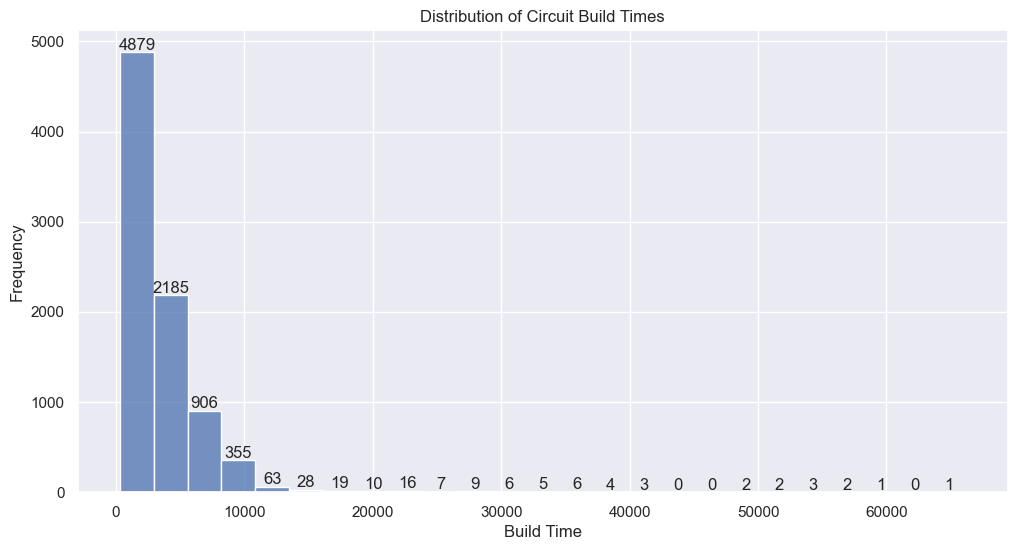

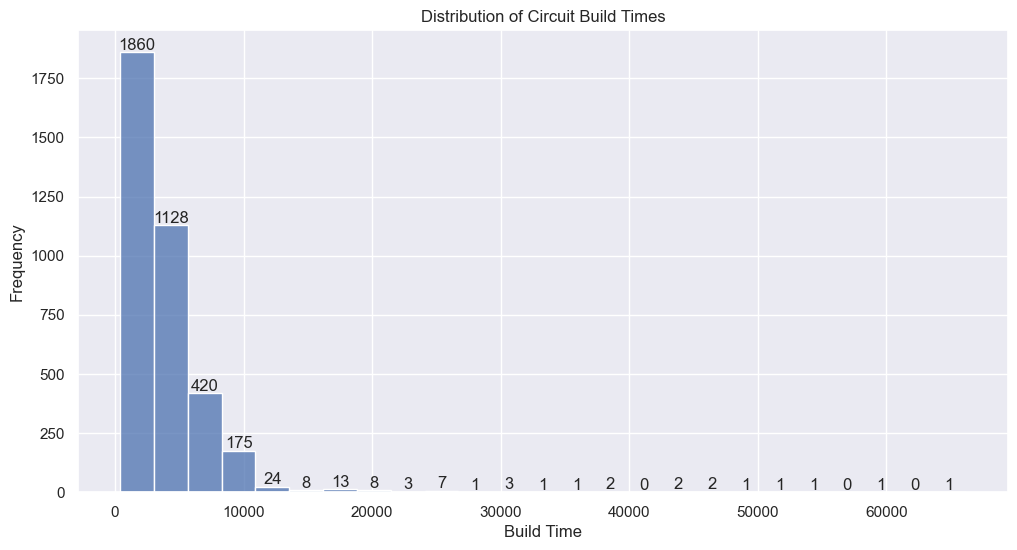

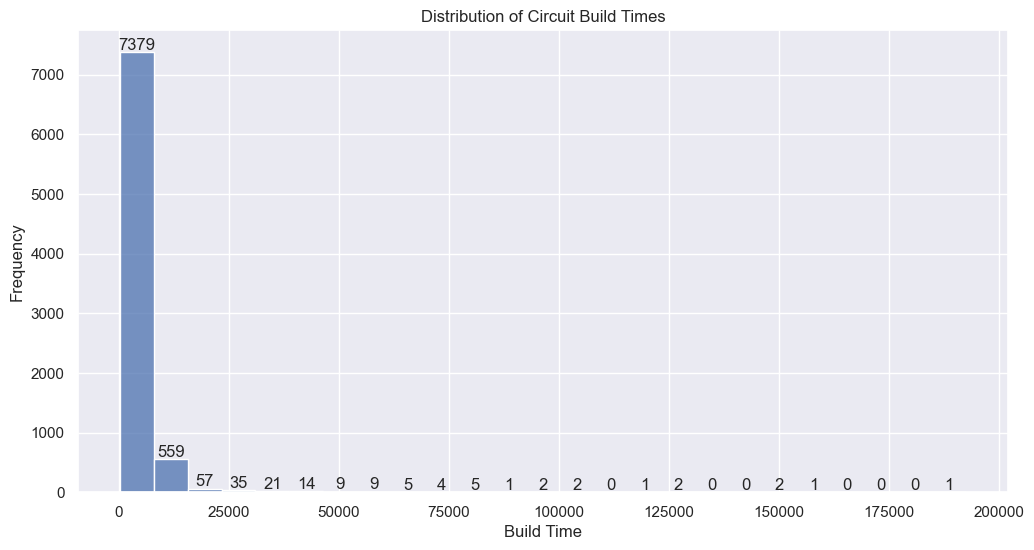

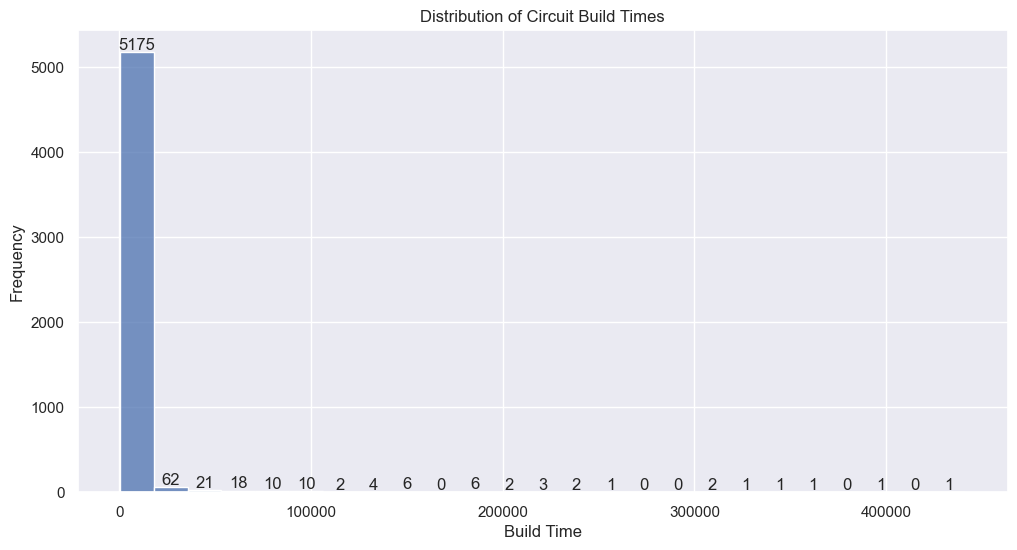

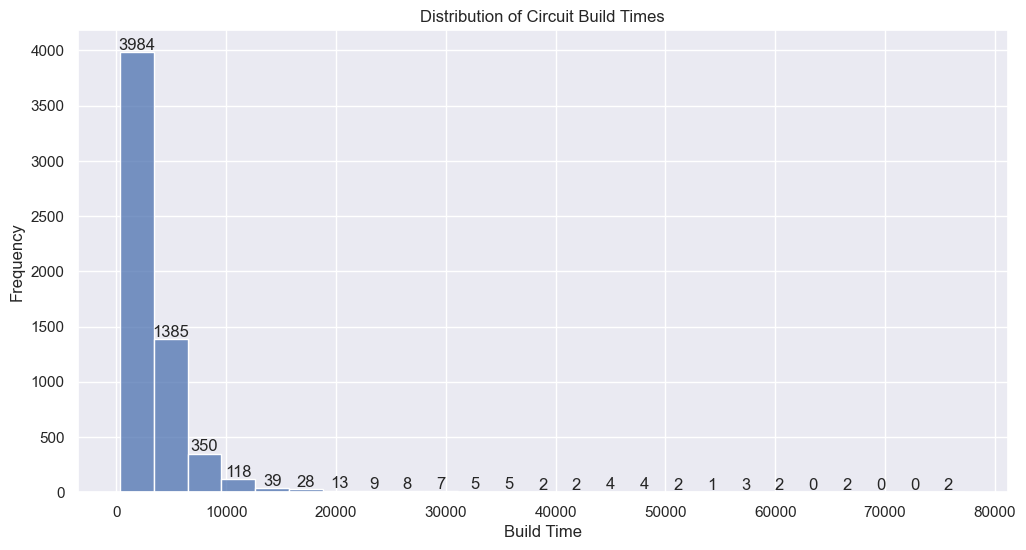

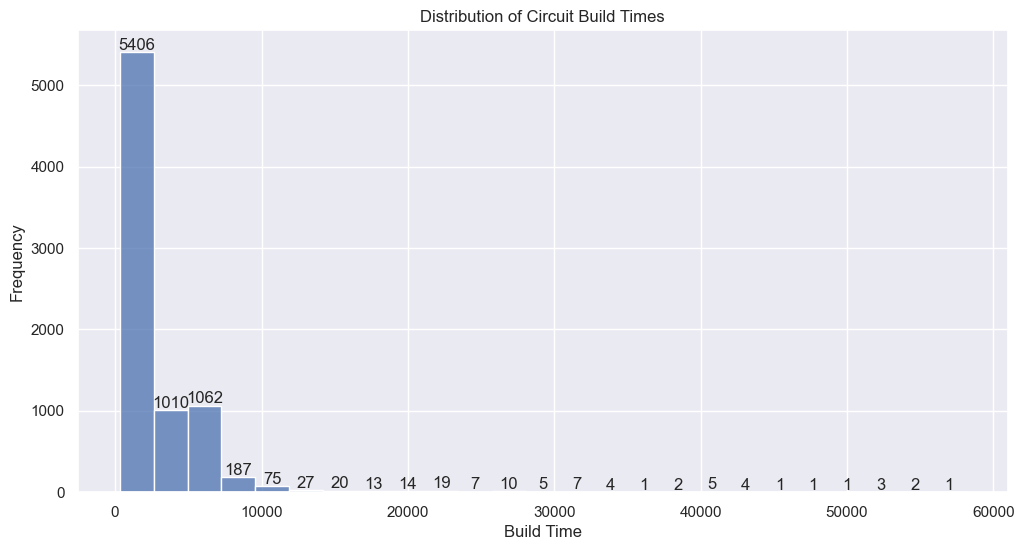

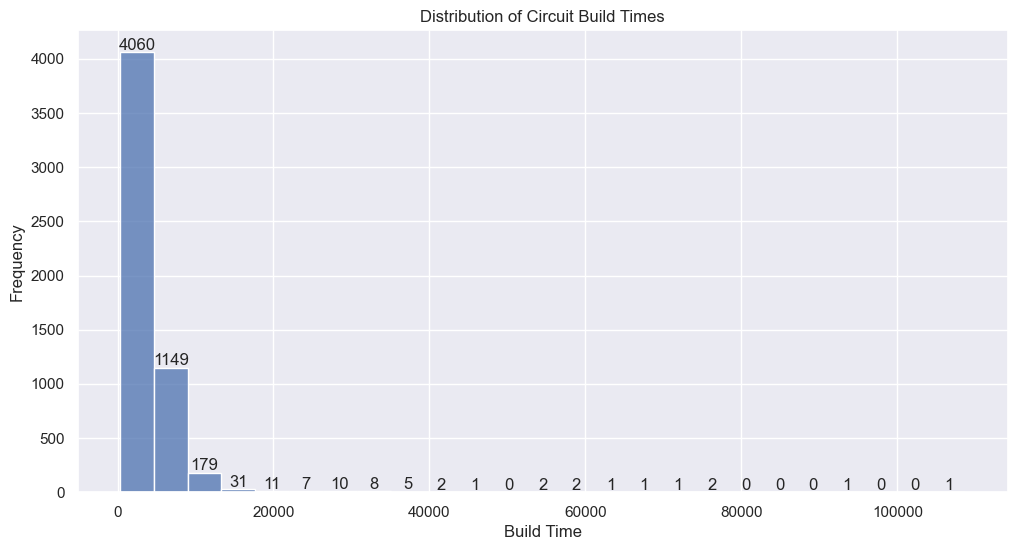

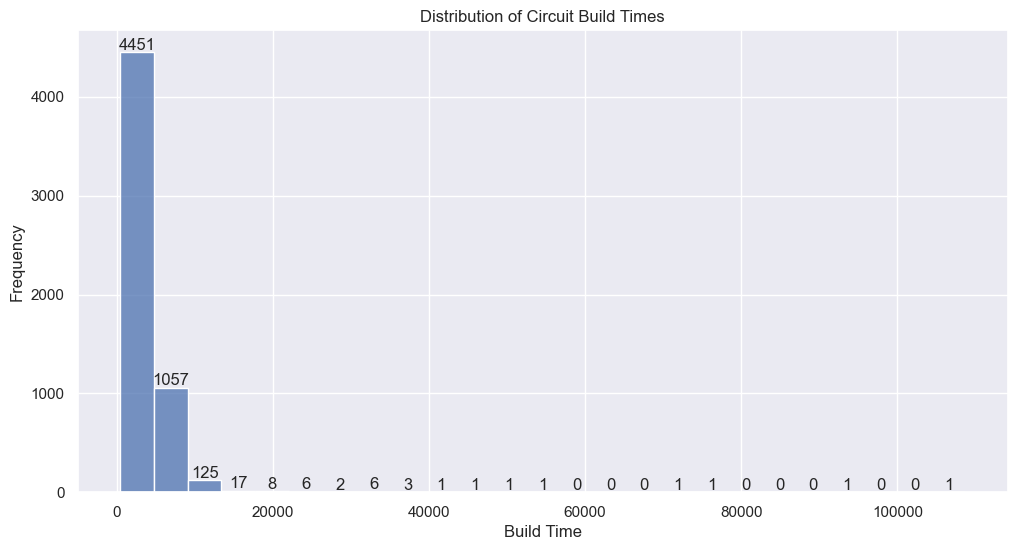

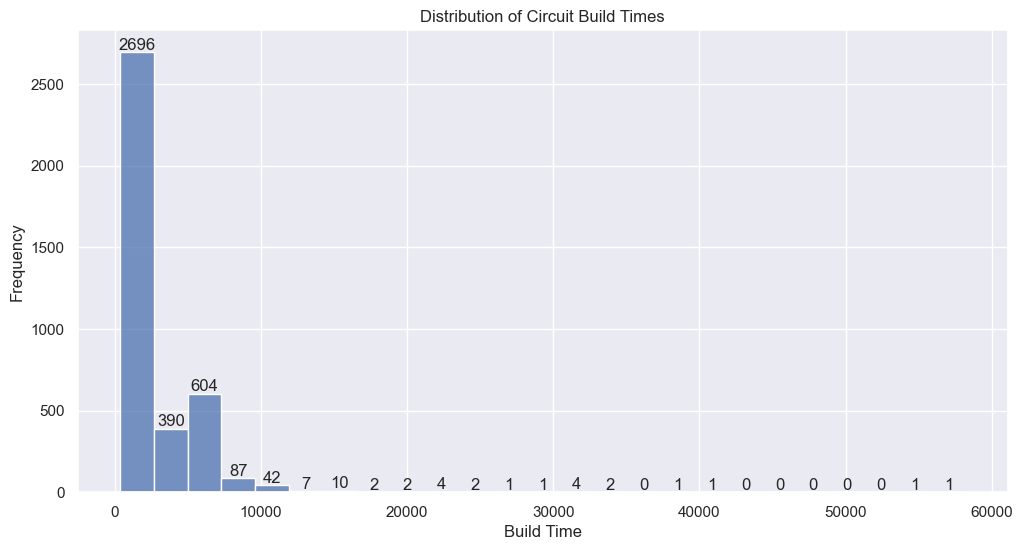

In [56]:
# build_times_filename = input("Enter filename of the build times file to use: ")
for i in range(1, 10):
    build_times_filename = f'5000_run_with_ublock_{i}.log_circuit_build_times_add_time.txt'
    build_times_file = f'../log_analysis/{build_times_filename}'
    output_file = f'../log_analysis/{build_times_filename}.png'
    circuit_build_times_histogram(build_times_file, output_file, build_times_filename)

Number of outliers: 1128
Minimum build time: 320.0
Maximum build time: 441367.0
Mean build time: 3483.200477151771


/tmp/ipykernel_402961/1195925164.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


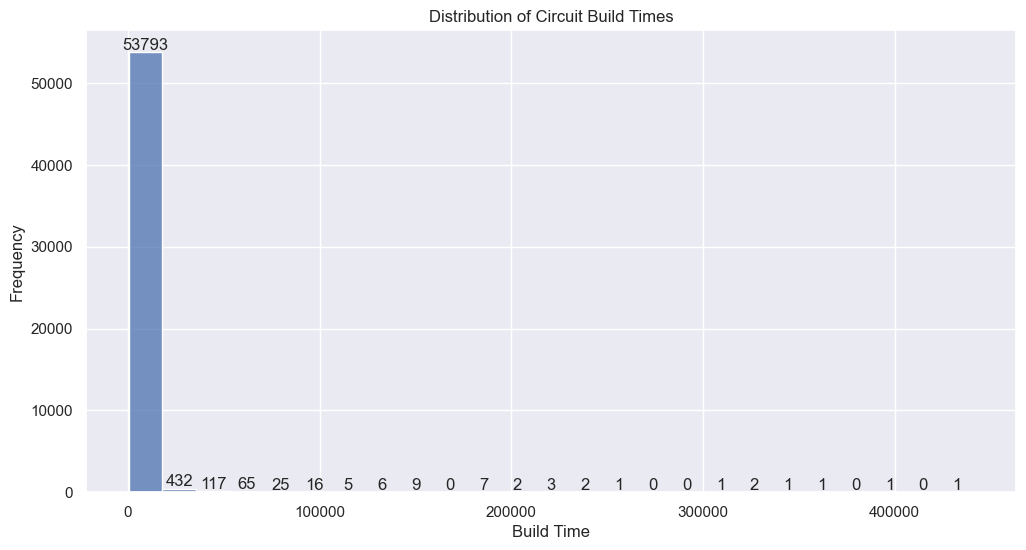

In [57]:
build_times_filename = input("Enter filename of the build times file to use: ")
build_times_file = f'../log_analysis/{build_times_filename}'
output_file = f'../log_analysis/{build_times_filename}.png'
circuit_build_times_histogram(build_times_file, output_file, build_times_filename)

In [23]:
def combine_files(input, output):
    with open(input, 'r') as input_file, open(output, 'a') as output_file:
        for line in input_file:
            output_file.write(line)

In [24]:
combine_files('../log_analysis/1_mil_no_ublock.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/1_mil_no_ublock_2.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/1_mil_no_ublock_3.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/1_mil_no_ublock_4.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')

combine_files('../log_analysis/5000_run_with_ublock_1.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_2.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_3.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_4.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_5.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_6.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_7.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_8.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
combine_files('../log_analysis/5000_run_with_ublock_9.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')